<a href="https://colab.research.google.com/github/lukemckinstry/fastai-projects/blob/master/ships.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *

### Get training Data From Drive

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')
# results = drive_service.files().list(
#         q="name = 'kaggle.json'", fields="files(id)").execute()
# kaggle_api_key = results.get('files', [])

# filename = "/root/.kaggle/kaggle.json"
# os.makedirs(os.path.dirname(filename), exist_ok=True)

# request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
# fh = io.FileIO(filename, 'wb')
# downloader = MediaIoBaseDownload(fh, request)
# done = False
# while done is False:
#     status, done = downloader.next_chunk()
#     print("Download %d%%." % int(status.progress() * 100))
# os.chmod(filename, 600)

In [0]:


def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records



In [5]:
train_file_name = 'ships_mini.zip'
label_file_name = 'train_ship_segmentations_v2.csv.zip'
train_drive_file_id = get_file_id(train_file_name)
label_drive_file_id = get_file_id(label_file_name)

DATA_DIR = Path('/content/data/ships_mini/')
DATA_DIR.mkdir(exist_ok=True, parents=True)
move_from_drive_to_disk([train_file_name], [DATA_DIR/train_file_name])
move_from_drive_to_disk([label_file_name], [DATA_DIR/label_file_name])
#!find '/content/' -type f -name \*.jpg -delete

Downloaded 72913034/72913034 bytes
Downloaded 18849010/18849010 bytes


In [0]:
!unzip -o {DATA_DIR}'/ships_mini.zip' -d {DATA_DIR}'/Train/'
!unzip -o {DATA_DIR}'/train_ship_segmentations_v2.csv.zip' -d {DATA_DIR}

In [11]:
!ls {DATA_DIR}
#!ls {DATA_DIR}/Train | wc -l

ships_mini.zip	train_ship_segmentations_v2.csv
Train		train_ship_segmentations_v2.csv.zip


In [0]:
label_df_raw = pd.read_csv(f'{DATA_DIR}/train_ship_segmentations_v2.csv', low_memory=False )
label_df_raw = label_df_raw.replace(np.nan, '', regex=True)

In [0]:
pd.set_option("display.max_colwidth", 10000)

In [9]:
#!less f'{DATA_DIR}/train_ship_segmentations_v2.csv'
#!ls '/content/data/ships_mini'
!less {DATA_DIR}/train_ship_segmentations_v2.csv

ImageId,EncodedPixels
00003e153.jpg,
0001124c7.jpg,
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269  33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413  33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556  33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700  33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844  33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988  33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131  33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275  33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419  33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563  33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706  34 331474 33 332242 33 333010 33 333778 33 33

In [30]:
#len( [i for i in label_df_raw])
ship_files = os.listdir('data/ships_mini/Train')
print(ship_files[0])
def in_mini(f):
  return f['ImageId'] in ship_files
#in_mini('00a802020.jpg')
masks = label_df_raw[label_df_raw.apply(in_mini, axis=1)]
masks.shape, label_df_raw.shape


00abc623a.jpg


((587, 2), (231723, 2))

In [31]:
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33 341458 33 342226 33 343003 24 343787 8
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 364321 10 365090 9 365858 10 366627 10 367396 9 368165 9 368933 10 369702 10 370471 9 371240 9 372009 9 372777 10 373546 9 374315 9 375084 7 375852 6 376621 3 377390 1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 7 56442 7 57210 7 57978 7 58746 7 59514 7 60282 7 61050 9 61818 9 62586 9 63354 9 64122 9 64890 9


## Write masks to jpgs in /labels

In [32]:
!mkdir {DATA_DIR}/label

mkdir: cannot create directory ‘/content/data/ships_mini/label’: File exists


In [0]:
dmasks = masks.to_dict()
for r in range( len( dmasks['ImageId'])):
  image_id = dmasks['ImageId'][r]
  filename = str( DATA_DIR/'label') + '/' + image_id
  rle_0 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels'].to_string(index=False)
  rle_mask = open_mask_rle( rle_0, [768,768])
  rle_mask.save( DATA_DIR/'label/{}'.format(image_id) )


### Look at images, try to write the masks

In [13]:
path_img = DATA_DIR/'Train/'
fnames = get_image_files(path_img)
fnames[:3]
#valid = fnames[-50:]
#len(fnames)
#[i.shape for i in fnames]

[PosixPath('/content/data/ships_mini/Train/00abc623a.jpg'),
 PosixPath('/content/data/ships_mini/Train/003b48a9e.jpg'),
 PosixPath('/content/data/ships_mini/Train/00140e597.jpg')]

/content/data/ships_mini/Train/00abc623a.jpg
torch.Size([768, 768])


(None, None)

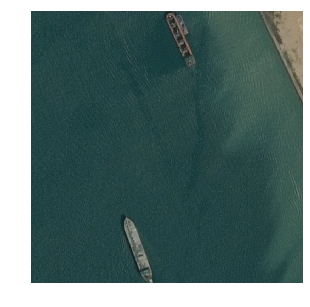

In [14]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))
print(img_f), print(img.size)
#open_image(img_f)

In [26]:
rle_0 = masks.query('ImageId=="002deeb16.jpg"')['EncodedPixels'].to_string(index=False)
rle_1 = masks.query('ImageId=="00003e153.jpg"')['EncodedPixels'].to_string(index=False)

print(type(rle_0))
derp = open_mask_rle( "", [768,768])

derp.save( DATA_DIR/'testmask.jpg')
print(rle_1)
print( type(derp), derp.shape)

<class 'str'>
NaN
<class 'fastai.vision.image.ImageSegment'> torch.Size([1, 768, 768])


In [27]:
!ls {DATA_DIR}

label		testmask.jpg  train_ship_segmentations_v2.csv
ships_mini.zip	Train	      train_ship_segmentations_v2.csv.zip


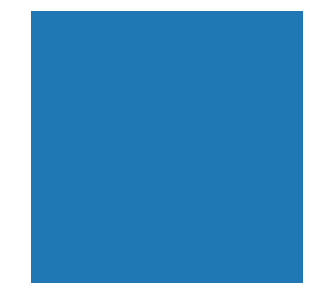

In [28]:
testmask = open_mask( DATA_DIR/'testmask.jpg' )
testmask.show(figsize=(5,5), alpha=1)


In [0]:

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    print( "how many masks? ", len(in_mask_list) )
    for mask in in_mask_list:
        
        if isinstance(mask, str):
            this_mask = rle_decode(mask, tuple([768, 768]))
            print( "this mask is type: ", type(this_mask) )
            all_masks += this_mask
    return np.expand_dims(all_masks, -1)

In [0]:
def open_mask_rle_list(mask_rle:str, shape:Tuple[int, int])->ImageSegment:
    "Return `ImageSegment` object create from run-length encoded string in `mask_lre` with size in `shape`."
    x = FloatTensor(rle_decode(str(mask_rle), shape).astype(np.uint8))
    x = x.view(shape[1], shape[0], -1)
    return ImageSegment(x.permute(2,0,1))

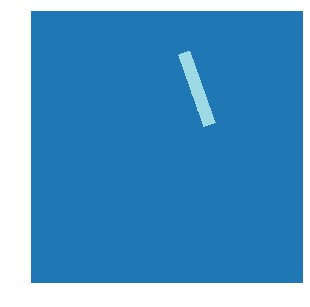

In [35]:
derp.show(figsize=(5,5), alpha=1)

In [0]:
### 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
#rle_0 = masks.query('ImageId=="0027854cc.jpg"')['EncodedPixels']
rle_0 = masks.query('ImageId=="00a9e2ec9.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
#rle_1 = multi_rle_encode(img_0)
#img_1 = masks_as_image(rle_1)
#ax2.imshow(img_1[:, :, 0])
#ax2.set_title('Image$_1$')
# print('Check Decoding->Encoding',
#       'RLE_0:', len(rle_0), '->',
#       'RLE_1:', len(rle_1))



In [0]:
codes = ['NotShip', 'Ship']

## Write images to files

## Try Prepping for data loader

In [0]:
#get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

def get_y_fn(y):
  print('ImageId=="{}"'.format(y).replace('/content/data/ships_mini/Train/',''))
  rle_0 = masks.query('ImageId=="{}"'.format(y))['EncodedPixels'].to_string(index=False)
  print(rle_0)
  return open_mask_rle( rle_0, [768,768])
#   print('here')
#   print( type(rle_0) )
#   print(rle_0)
#   img_0 = masks_as_image(rle_0)
#  return img_0
  
  
  #= lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [0]:
def get_y_fn(y):
    print(y)
    print(type(y))
    print( str(y).replace('/content/data/ships_mini/Train/','') )
    print( str( DATA_DIR/'label/') + '/'+str(y).replace('/content/data/ships_mini/Train/','') )
    return str( DATA_DIR/'label/') + '/'+ str(y).replace('/content/data/ships_mini/Train/','') 
  


#get_y_fn = lambda x: str( {DATA_DIR}/'label/') + x.replace('/content/data/ships_mini/Train/','')
#str( DATA_DIR/'label') + '/' + image_id

In [80]:
!ls {path_img} | wc -l 

500


In [0]:
src_size = np.array(masks.shape[1:])
size = src_size//2
bs=8

In [0]:
path_img = str(DATA_DIR/'Train')

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .random_split_by_pct(valid_pct=0.2)
       .label_from_func(get_y_fn, classes=codes))

In [67]:
path_img

'/content/data/ships_mini'

In [0]:
# data = (src.transform(get_transforms(), size=size, tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))
data = (src.databunch(bs=bs)
        .normalize(imagenet_stats))

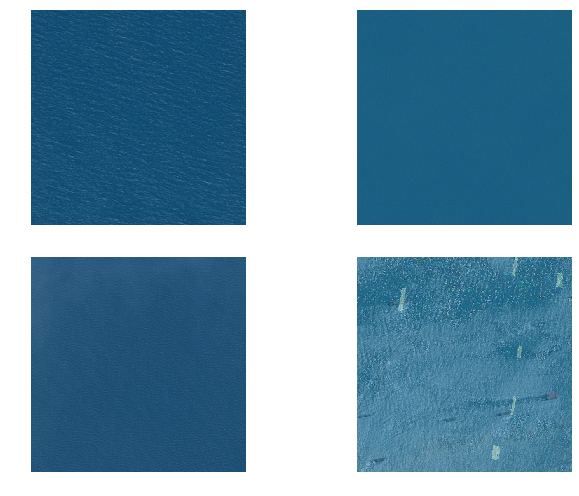

In [74]:
data.show_batch(2, figsize=(10,7))

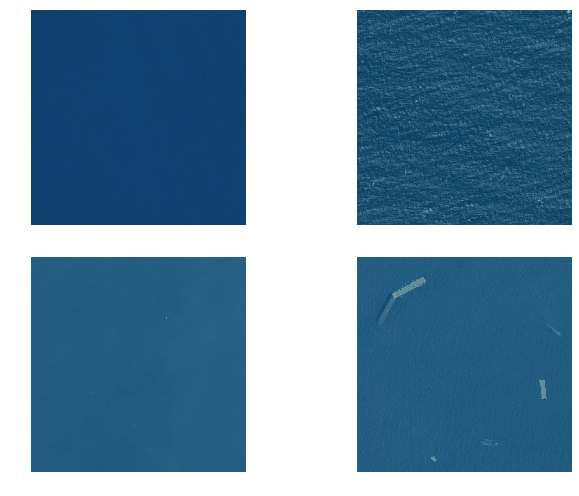

In [75]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### Upload 500 ship traininxg image files from Google Drive folder

In [0]:
ship_train_results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()

In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/images/0001TP_008160.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0016E5_08041.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0006R0_f02340.png')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05400_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0006R0_f02640_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05340_P.png')]

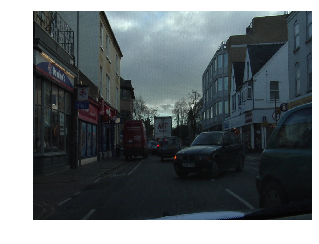

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

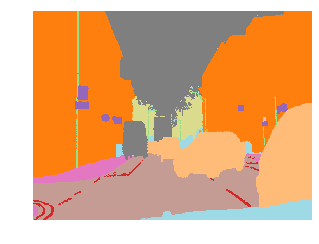

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [0]:
size = src_size//2
bs=8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

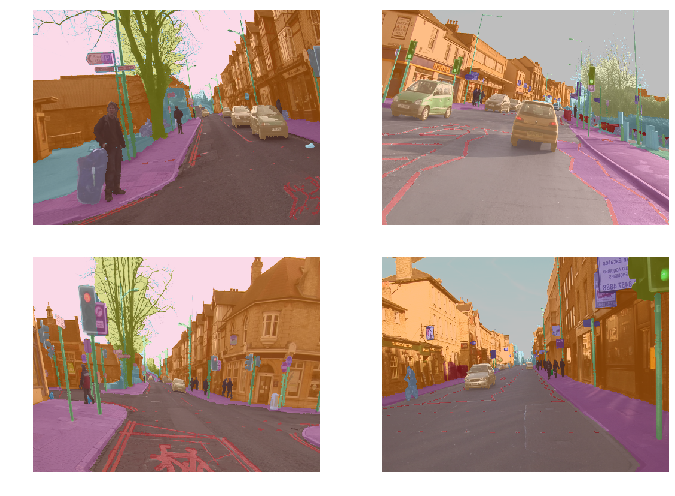

In [0]:
data.show_batch(2, figsize=(10,7))

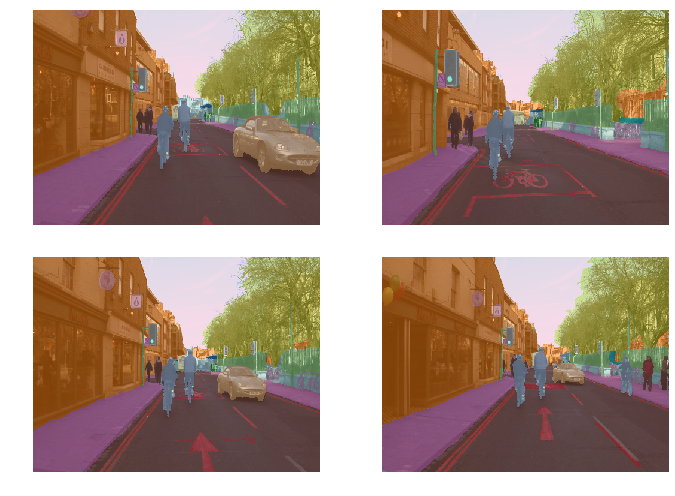

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


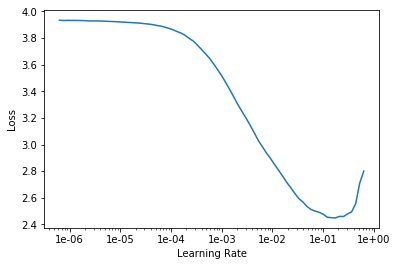

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.172738,0.771233,0.820753
2,0.799105,0.637969,0.825231
3,0.731867,0.628517,0.824456
4,0.630086,0.486045,0.860029
5,0.616145,0.535374,0.860695
6,0.588540,0.439988,0.879501
7,0.551265,0.412592,0.884478
8,0.568172,0.679087,0.832221
9,0.538392,0.405911,0.879605
10,0.451235,0.353972,0.892891


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

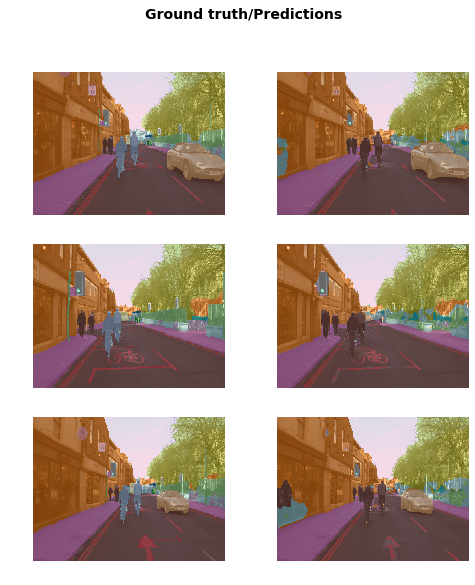

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.389135,0.334715,0.896700
2,0.377873,0.324080,0.900284
3,0.369020,0.325073,0.904146
4,0.355022,0.308820,0.912556
5,0.351138,0.313001,0.909351
6,0.347777,0.285509,0.920183
7,0.338683,0.306076,0.909899
8,0.318913,0.303712,0.915792
9,0.312038,0.276126,0.920137
10,0.311217,0.276649,0.925244


In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=3

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


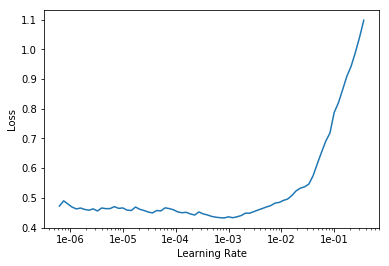

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

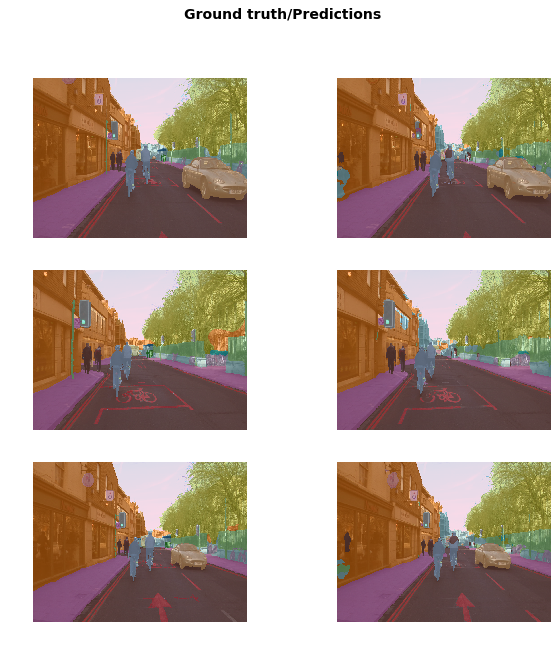

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## fin